# Hauling Opeartion Simulation
This Notebook models and simulates the hauling operation using the OpenCLSim package, incorporating:

- Hauling Cycle: Drive empty-load-drive full-unload
- Queuing at source and destination
- One type of material (Waste) 
- Importing the number of trucks, truck-shovel allocations, and hauling scenarios from designated files

In [52]:
import networkx as nx  
import shapely.geometry
import pyproj


import datetime as dt
import time
import simpy
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot
import opentnsim

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import folium
import logging

In [81]:
def run(total_waste):
    # Read the CSV file
    file_path = 'HaulageOperation_TruckDetails.csv'
    df = pd.read_csv(file_path)

    # Create an empty list to store information about each truck
    truck_list = []

    # Initialize a counter for overall truck numbering
    overall_truck_counter = 1

    # Iterate through rows and repeat based on the number of trucks
    for index, row in df.iterrows():
        # Convert 'Number of trucks' to integer
        num_trucks = int(row['Number of Trucks'])

        for truck_num in range(num_trucks):
            # Create a dictionary for each truck
            truck_info = {
                'ID': row['ID'],
                'Name of the trucks': f'truck{overall_truck_counter}',
                'Type': row['Type'],
                'Payload (Ton)': row['Payload (Ton)'],
                'Minimum Speed (Mile/Hour)': row['Minimum Speed (Mile/Hour)'],
                'Maximum Speed (Mile/Hour)': row['Maximum Speed (Mile/Hour)'],
                'Unloading Time (Minute)': row['Unloading Time (Minute)'],
                'Param 1': row['Param 1'],
                'Param 2': row['Param 2']
            }
            # Increment the overall truck counter
            overall_truck_counter += 1

            # Append the truck information to the list
            truck_list.append(truck_info)

    # Create a new data frame from the list
    df_result = pd.DataFrame(truck_list)

    # Calculate the total number of trucks as an integer
    # total_trucks = int(df['Number of Trucks'].sum())
    total_trucks = 2
    # create a Site object based on desired mixin classes
    Site = type('Site',
                (core.Identifiable,
                 core.Log,
                 core.Locatable,
                 core.HasContainer,
                 core.HasResource,), {})

    # create a TransportProcessingResource object based on desired mixin classes
    TransportProcessingResource = type(
        "TransportProcessingResource",
        (
         core.ContainerDependentMovable,
         core.Processor,
         core.HasResource,
         core.LoadingFunction,
         core.UnloadingFunction,
         core.Identifiable,
         core.Log,
        ),
        {},
    )
    
    simulation_start = 0
    my_env = simpy.Environment(initial_time=simulation_start)
    registry = {}

    # prepare input data for source
    location_source01 = shapely.geometry.Point(4.062705498083785, 51.95909715255291)
    data_source01 = {"env": my_env,
                     "name": "source01",
                     "geometry": location_source01,
                     "capacity": total_waste,
                     "level": total_waste
                   # "nr_resources": 1
                    }
    source01 = Site(**data_source01)
    
    # prepare input data for dump
    location_dump01 = shapely.geometry.Point(4.1795229742823, 52.11590591837503)
    data_dump01 = {"env": my_env,
                   "name": "dump01",
                   "geometry": location_dump01,
                   "capacity": total_waste,
                   "level": 0
                  }
    dump01 = Site(**data_dump01)

    # create truck objects
    trucks = {}

    for i in range(1, total_trucks + 1):
        # Extract information from the truck list
        truck_info = df_result[df_result['Name of the trucks'] == f'truck{i}'].iloc[0]

        # Extract unloading time distribution parameters
        mean_unloading_time = truck_info['Param 1']
        std_dev_unloading_time = truck_info['Param 2']
        # Generate random unloading time from the specified distribution
        unloading_rate = np.random.normal(loc=mean_unloading_time, scale=std_dev_unloading_time)

        # Create an instance of TransportProcessingResource
        trucks[f"truck{i}"] = TransportProcessingResource(
            env=my_env,
            name=f"truck{i}",
            geometry=location_dump01,
            # level=0,
            loading_rate=1,
            unloading_rate=unloading_rate,
            capacity= truck_info['Payload (Ton)'],
            compute_v=lambda x: 10 + 2 * x,
        )

   # Create activity objects
    activities_d_truck = {}

    for i in range(1, total_trucks + 1):
        # requested_resources = {}
        truck = trucks[f"truck{i}"]
        d_subprocesses = [
            model.MoveActivity(
                env=my_env,
                name=f"driving_empty:" + trucks[f"truck{i}"].name,
                registry=registry,
                mover=trucks[f"truck{i}"],
                destination=source01,
                # duration=20,
            ),
            model.ShiftAmountActivity(
                env=my_env,
                name=f"loading:" + trucks[f"truck{i}"].name,
                registry=registry,
                processor=trucks[f"truck{i}"],
                origin=source01,
                destination=trucks[f"truck{i}"],
                amount=20,
                duration=50,
                # id_="waste",
            ),
            model.MoveActivity(
                env=my_env,
                name=f"driving_full:" + trucks[f"truck{i}"].name,
                registry=registry,
                mover=trucks[f"truck{i}"],
                destination=dump01,
                # duration=15,
            ),
            model.ShiftAmountActivity(
                env=my_env,
                name=f"unloading:" + trucks[f"truck{i}"].name,
                registry=registry,
                processor=trucks[f"truck{i}"],
                origin=trucks[f"truck{i}"],
                destination=dump01,
                amount=20,
                duration=25,
                # id_="waste",
            )
        ]
        activities_d_truck[f"activities_d_truck{i}"] = model.WhileActivity(
            env=my_env,
            name=f"while_sequential_activity_d_truck{i}",
            registry=registry,
            sub_processes=[model.SequentialActivity(
                env=my_env,
                name=f"sequential_activity_d_truck{i}",
                registry=registry,
                sub_processes=d_subprocesses
            )],
            condition_event=[{"type": "container",
                              "concept": dump01,
                              "state": "gt", "level":460}
                             ]
        )
    
    processes=[*activities_d_truck.values()]
    print(processes)
    model.register_processes(processes)
    try: 
        my_env.run()
    except:
        logging.exception('run did not succeed')
        
    return {
        "trucks": trucks,
        "activities_d_truck": activities_d_truck,
        "source01": source01,
        "dump01": dump01,
        "total_trucks": total_trucks,  # Adding total_trucks to the returned dictionary
        "registry": registry,
    }

In [82]:
# Example usage: 
res = run(500)
trucks = res['trucks']
activities_d_truck = res['activities_d_truck']
source01 = res['source01']
dump01 = res['dump01']
total_trucks = res['total_trucks']  # Extracting total_trucks
registry = res['registry']

[<openclsim.model.while_activity.WhileActivity object at 0x7f9d38a40e50>, <openclsim.model.while_activity.WhileActivity object at 0x7f9d38a40d00>]


In [83]:
print(source01.container.capacity, source01.container.items)

2 [{'id': 'default', 'capacity': 500, 'level': 0}, {'id': 'default_reservations', 'capacity': 500, 'level': 0}]


In [84]:
print(source01.container.get_level())

0


In [85]:
print(dump01.container.capacity, dump01.container.items)

2 [{'id': 'default', 'capacity': 500, 'level': 500}, {'id': 'default_reservations', 'capacity': 500, 'level': 500}]


In [68]:
truck1 = trucks['truck1']
pd.DataFrame(truck1.logbook)
pd.DataFrame(dump01.logbook)


,Timestamp,ActivityID,ActivityState,ObjectState,ActivityLabel
0,1970-01-01 01:03:36.375536,434475ae-fd7f-478b-95a4-c00a12914b31,START,"{'container level': 0, 'geometry': POINT (4.17...",{}
1,1970-01-01 01:04:01.375536,434475ae-fd7f-478b-95a4-c00a12914b31,STOP,"{'container level': 20, 'geometry': POINT (4.1...",{}
2,1970-01-01 01:04:26.375536,7c57a886-5181-4570-bd66-74f21da1a188,START,"{'container level': 20, 'geometry': POINT (4.1...",{}
3,1970-01-01 01:04:51.375536,7c57a886-5181-4570-bd66-74f21da1a188,STOP,"{'container level': 40, 'geometry': POINT (4.1...",{}


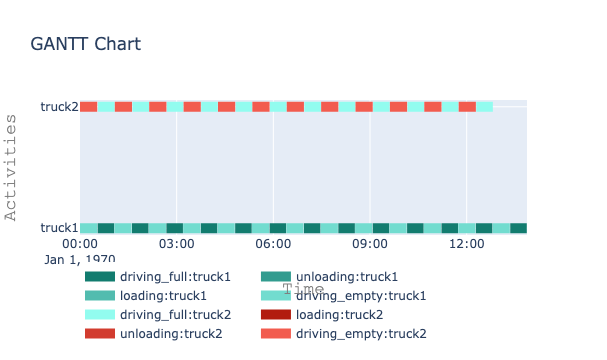

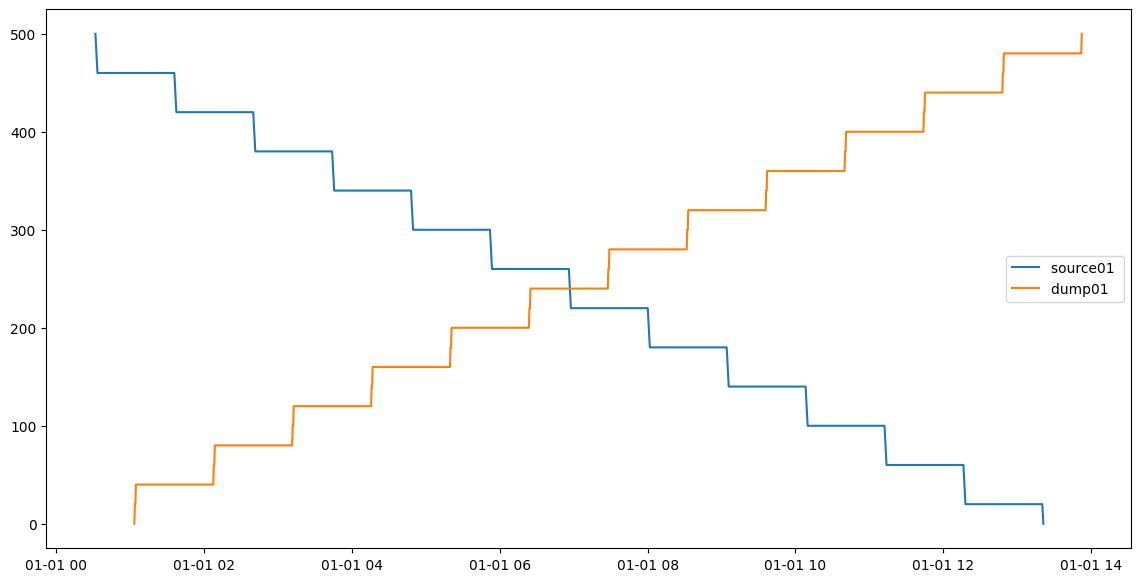

In [86]:
# Plotting
fig_gantt = plot.get_gantt_chart([*trucks.values()], id_map=[*activities_d_truck.values()])
fig_step = plot.get_step_chart([source01, dump01])
